# How well can a machine learning algorithm classify hand-written digits?
In this Kaggle competition [Digit Recongnizer](https://www.kaggle.com/c/digit-recognizer), our goal is to build a best digit recongnizer that can recongnize hand-written digits with the accuracy close to or even better than whtat humans can do. 

In [2]:
#loading necessary module 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Dense
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
from collections import Counter
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model


### Load Kaggle MINIST data (42,000 training images, and 28,000 test images)

In [3]:
df_train_orig = pd.read_csv('./train.csv')
df_test_orig = pd.read_csv('./test.csv')

print('Shape of train data: {}'.format(df_train_orig.shape))
print('Shape of test data: {}'.format(df_test_orig.shape))

df_train_orig.head()

Shape of train data: (42000, 785)
Shape of test data: (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#prepare input and label for training data
df_train_X = df_train_orig.iloc[:,1:]
df_train_Y = pd.DataFrame(df_train_orig.iloc[:,0])
df_test_X = df_test_orig

print('Shape of df_train_X: {}'.format(df_train_X.shape))
print('Shape of df_train_Y: {}'.format(df_train_Y.shape))
print('Shape of df_test_X: {}'.format(df_test_X.shape))

Shape of df_train_X: (42000, 784)
Shape of df_train_Y: (42000, 1)
Shape of df_test_X: (28000, 784)


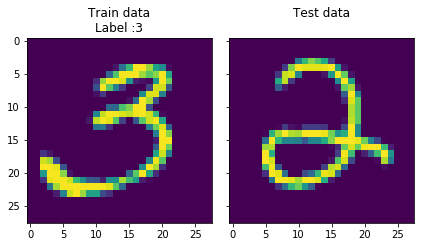

In [5]:
##Display one example for train and test data randomly 
index1=np.random.randint(df_train_X.shape[0])
tmp1=df_train_X.iloc[index1,:].values.reshape(28,28)
index2=np.random.randint(df_test_X.shape[0])
tmp2=df_test_X.iloc[index2,:].values.reshape(28,28)

fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(tmp1)
ax[0].set_title("Train data\nLabel :{}".format(df_train_Y.iloc[index1,:][0]))
ax[1].imshow(tmp2)
ax[1].set_title("Test data\n")
plt.tight_layout()

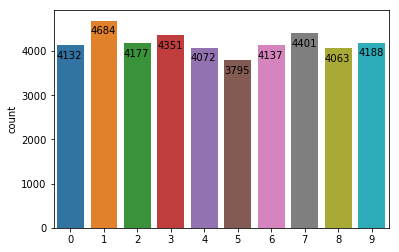

In [6]:
#check the histogram of digits on training data
ax = sns.countplot(np.squeeze(df_train_Y.values))
for p in ax.patches:
    ax.annotate('{:d}'.format(p.get_height()), (p.get_x(), p.get_height()-300))


The histogram shows that the total number of each digit is quite balanced in the training data

## Prepare training and test data
Here we do a few things to prepare the input data:<br>
1. check NaN
2. check maximum value in the data and do normalization
3. reshape each images to 28x28 pixels
4. encode labels to one hot vectors

In [7]:
#Check NaN in train and test data
print('Any NaN in train data?: {}'.format(df_train_orig.isnull().any().any()))
print('Any NaN in test data?: {}'.format(df_test_orig.isnull().any().any()))

Any NaN in train data?: False
Any NaN in test data?: False


In [8]:
#Check maximum value in train/test data, and normalize them
max_train = df_train_X.max().max()
max_test = df_test_X.max().max()
print('Maximum value in train data: {}'.format(max_train))
print('Maximum value in test data: {}'.format(max_test))

df_train_X = df_train_X / max_train
df_test_X = df_test_X / max_test

Maximum value in train data: 255
Maximum value in test data: 255


In [9]:
print('df_train_X.shape before reshape: {}'.format(df_train_X.shape))

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
df_train_X = df_train_X.values.reshape(-1,28,28,1)
df_test_X = df_test_X.values.reshape(-1,28,28,1)

print('df_train_X.shape after reshape: {}'.format(df_train_X.shape))

df_train_X.shape before reshape: (42000, 784)
df_train_X.shape after reshape: (42000, 28, 28, 1)


In [10]:
print('df_train_Y.shape before encoding: {}'.format(df_train_Y.shape))

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
df_train_Y = to_categorical(df_train_Y, num_classes = 10)

print('df_train_Y.shape after encoding: {}'.format(df_train_Y.shape))

df_train_Y.shape before encoding: (42000, 1)
df_train_Y.shape after encoding: (42000, 10)


### Generate more images from 42,000 training images by data augmentation

In [12]:
#create more images via data augmentation (with different rotation, shift, and zoom range) 
datagen = ImageDataGenerator(
        rotation_range=9,  
        zoom_range = 0.09,  
        width_shift_range=0.09, 
        height_shift_range=0.09)

True label: 0 , 7, 2


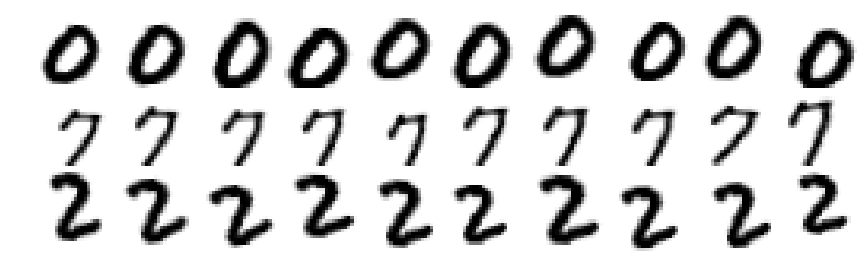

In [14]:
#preview augmented images
index=np.random.randint(df_train_X.shape[0]-100 , size=3)
X_train3 = df_train_X[index[0],].reshape((1,28,28,1))
Y_train3 = df_train_Y[index[0],].reshape((1,10))
print('True label: {} , {}, {}'.format(np.argmax(df_train_Y[index[0]]),np.argmax(df_train_Y[index[1]]),np.argmax(df_train_Y[index[2]])))
plt.figure(figsize=(15,4.5))
true_label=[]
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = df_train_X[index[1],].reshape((1,28,28,1))
    if i==19: X_train3 = df_train_X[index[2],].reshape((1,28,28,1))
    true_label.append(Y_train2)
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

## Build 5 convolutional neural networks

<img src="http://playagricola.com/Kaggle/LeNet5.png" width="900">
Architecture of LeNet-5

The CNNs in this kernel follow [LeNet5's](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) design with the few improvements:

1. ReLU activation replaces sigmoid.
2. Batch normalization is added
3. Dropout is added
4. More feature channels are added
5. An ensemble of 5 CNNs with bagging is used


In [32]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 5
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.15))
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.15))
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.15))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.15))
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.15))
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.15))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(Dropout(0.15))
    model[j].add(Flatten())
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(0.3))
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(0.3))
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(0.3))
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(0.3))
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(0.3))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    adam =Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model[j].compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
model[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_73 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_133 (Dropout)        (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_74 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_134 (Dropout)        (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 12, 12, 32)        25632     
__________

## Train 5 CNNs

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='acc', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.75, 
                                            min_lr=0)

In [36]:
# TRAIN NETWORKS
history = [0] * nets
epochs = 150
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(df_train_X, df_train_Y, test_size = 0.2)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), verbose=2, callbacks=[learning_rate_reduction])
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

Epoch 1/150
 - 15s - loss: 0.9375 - acc: 0.6825 - val_loss: 0.2231 - val_acc: 0.9582
Epoch 2/150
 - 9s - loss: 0.2402 - acc: 0.9462 - val_loss: 0.0774 - val_acc: 0.9829
Epoch 3/150
 - 9s - loss: 0.1658 - acc: 0.9637 - val_loss: 0.0506 - val_acc: 0.9876
Epoch 4/150
 - 9s - loss: 0.1376 - acc: 0.9711 - val_loss: 0.0815 - val_acc: 0.9838
Epoch 5/150
 - 9s - loss: 0.1197 - acc: 0.9746 - val_loss: 0.0955 - val_acc: 0.9813
Epoch 6/150
 - 9s - loss: 0.1058 - acc: 0.9776 - val_loss: 0.0463 - val_acc: 0.9898
Epoch 7/150
 - 9s - loss: 0.0997 - acc: 0.9794 - val_loss: 0.0508 - val_acc: 0.9888
Epoch 8/150
 - 9s - loss: 0.0910 - acc: 0.9809 - val_loss: 0.0520 - val_acc: 0.9902
Epoch 9/150
 - 9s - loss: 0.0912 - acc: 0.9811 - val_loss: 0.0543 - val_acc: 0.9896
Epoch 10/150
 - 9s - loss: 0.0837 - acc: 0.9823 - val_loss: 0.0522 - val_acc: 0.9885
Epoch 11/150
 - 9s - loss: 0.0763 - acc: 0.9842 - val_loss: 0.0487 - val_acc: 0.9906
Epoch 12/150
 - 9s - loss: 0.0732 - acc: 0.9844 - val_loss: 0.0562 - val_

Epoch 96/150
 - 9s - loss: 0.0208 - acc: 0.9953 - val_loss: 0.0295 - val_acc: 0.9948
Epoch 97/150
 - 9s - loss: 0.0226 - acc: 0.9945 - val_loss: 0.0313 - val_acc: 0.9949
Epoch 98/150
 - 9s - loss: 0.0194 - acc: 0.9958 - val_loss: 0.0358 - val_acc: 0.9943
Epoch 99/150
 - 9s - loss: 0.0198 - acc: 0.9955 - val_loss: 0.0307 - val_acc: 0.9958
Epoch 100/150
 - 9s - loss: 0.0213 - acc: 0.9954 - val_loss: 0.0336 - val_acc: 0.9943
Epoch 101/150
 - 9s - loss: 0.0177 - acc: 0.9960 - val_loss: 0.0337 - val_acc: 0.9949
Epoch 102/150
 - 9s - loss: 0.0155 - acc: 0.9965 - val_loss: 0.0314 - val_acc: 0.9950
Epoch 103/150
 - 9s - loss: 0.0193 - acc: 0.9958 - val_loss: 0.0283 - val_acc: 0.9956
Epoch 104/150
 - 9s - loss: 0.0190 - acc: 0.9959 - val_loss: 0.0406 - val_acc: 0.9939
Epoch 105/150
 - 9s - loss: 0.0219 - acc: 0.9955 - val_loss: 0.0270 - val_acc: 0.9954
Epoch 106/150
 - 9s - loss: 0.0185 - acc: 0.9958 - val_loss: 0.0312 - val_acc: 0.9950
Epoch 107/150
 - 9s - loss: 0.0162 - acc: 0.9964 - val_los

Epoch 39/150
 - 9s - loss: 0.0404 - acc: 0.9914 - val_loss: 0.0322 - val_acc: 0.9927
Epoch 40/150
 - 9s - loss: 0.0471 - acc: 0.9902 - val_loss: 0.0273 - val_acc: 0.9937
Epoch 41/150
 - 9s - loss: 0.0404 - acc: 0.9912 - val_loss: 0.0326 - val_acc: 0.9933
Epoch 42/150
 - 9s - loss: 0.0375 - acc: 0.9922 - val_loss: 0.0306 - val_acc: 0.9940
Epoch 43/150
 - 9s - loss: 0.0454 - acc: 0.9903 - val_loss: 0.0285 - val_acc: 0.9939
Epoch 44/150
 - 9s - loss: 0.0463 - acc: 0.9907 - val_loss: 0.0331 - val_acc: 0.9936
Epoch 45/150
 - 9s - loss: 0.0402 - acc: 0.9909 - val_loss: 0.0272 - val_acc: 0.9944
Epoch 46/150
 - 9s - loss: 0.0449 - acc: 0.9905 - val_loss: 0.0499 - val_acc: 0.9912
Epoch 47/150
 - 9s - loss: 0.0458 - acc: 0.9906 - val_loss: 0.0241 - val_acc: 0.9948
Epoch 48/150
 - 9s - loss: 0.0416 - acc: 0.9920 - val_loss: 0.0245 - val_acc: 0.9949
Epoch 49/150
 - 9s - loss: 0.0399 - acc: 0.9917 - val_loss: 0.0234 - val_acc: 0.9940
Epoch 50/150
 - 9s - loss: 0.0419 - acc: 0.9915 - val_loss: 0.026

Epoch 132/150
 - 9s - loss: 0.0134 - acc: 0.9968 - val_loss: 0.0263 - val_acc: 0.9954

Epoch 00132: ReduceLROnPlateau reducing learning rate to 0.00023730468819849193.
Epoch 133/150
 - 9s - loss: 0.0111 - acc: 0.9977 - val_loss: 0.0248 - val_acc: 0.9956
Epoch 134/150
 - 9s - loss: 0.0113 - acc: 0.9974 - val_loss: 0.0260 - val_acc: 0.9951
Epoch 135/150
 - 9s - loss: 0.0138 - acc: 0.9972 - val_loss: 0.0240 - val_acc: 0.9948
Epoch 136/150
 - 9s - loss: 0.0144 - acc: 0.9971 - val_loss: 0.0253 - val_acc: 0.9951
Epoch 137/150
 - 9s - loss: 0.0130 - acc: 0.9973 - val_loss: 0.0237 - val_acc: 0.9956
Epoch 138/150
 - 9s - loss: 0.0112 - acc: 0.9973 - val_loss: 0.0258 - val_acc: 0.9946
Epoch 139/150
 - 9s - loss: 0.0107 - acc: 0.9976 - val_loss: 0.0238 - val_acc: 0.9952
Epoch 140/150
 - 9s - loss: 0.0099 - acc: 0.9977 - val_loss: 0.0240 - val_acc: 0.9957
Epoch 141/150
 - 9s - loss: 0.0111 - acc: 0.9974 - val_loss: 0.0273 - val_acc: 0.9951
Epoch 142/150
 - 9s - loss: 0.0109 - acc: 0.9974 - val_los

Epoch 75/150
 - 10s - loss: 0.0286 - acc: 0.9937 - val_loss: 0.0219 - val_acc: 0.9949
Epoch 76/150
 - 10s - loss: 0.0258 - acc: 0.9941 - val_loss: 0.0236 - val_acc: 0.9956
Epoch 77/150
 - 9s - loss: 0.0262 - acc: 0.9942 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 78/150
 - 9s - loss: 0.0247 - acc: 0.9942 - val_loss: 0.0209 - val_acc: 0.9958
Epoch 79/150
 - 10s - loss: 0.0287 - acc: 0.9938 - val_loss: 0.0226 - val_acc: 0.9958
Epoch 80/150
 - 10s - loss: 0.0235 - acc: 0.9948 - val_loss: 0.0207 - val_acc: 0.9961
Epoch 81/150
 - 10s - loss: 0.0288 - acc: 0.9935 - val_loss: 0.0247 - val_acc: 0.9946
Epoch 82/150
 - 10s - loss: 0.0301 - acc: 0.9935 - val_loss: 0.0166 - val_acc: 0.9964
Epoch 83/150
 - 10s - loss: 0.0265 - acc: 0.9942 - val_loss: 0.0198 - val_acc: 0.9958
Epoch 84/150
 - 10s - loss: 0.0295 - acc: 0.9937 - val_loss: 0.0187 - val_acc: 0.9960
Epoch 85/150
 - 11s - loss: 0.0267 - acc: 0.9945 - val_loss: 0.0203 - val_acc: 0.9955
Epoch 86/150
 - 10s - loss: 0.0274 - acc: 0.9940 - val_l

Epoch 16/150
 - 9s - loss: 0.0667 - acc: 0.9857 - val_loss: 0.0393 - val_acc: 0.9927
Epoch 17/150
 - 9s - loss: 0.0637 - acc: 0.9861 - val_loss: 0.0552 - val_acc: 0.9896
Epoch 18/150
 - 9s - loss: 0.0612 - acc: 0.9879 - val_loss: 0.0309 - val_acc: 0.9936
Epoch 19/150
 - 10s - loss: 0.0625 - acc: 0.9859 - val_loss: 0.0294 - val_acc: 0.9933
Epoch 20/150
 - 10s - loss: 0.0584 - acc: 0.9872 - val_loss: 0.0272 - val_acc: 0.9937
Epoch 21/150
 - 10s - loss: 0.0592 - acc: 0.9873 - val_loss: 0.0489 - val_acc: 0.9893
Epoch 22/150
 - 10s - loss: 0.0586 - acc: 0.9873 - val_loss: 0.0319 - val_acc: 0.9933
Epoch 23/150
 - 9s - loss: 0.0532 - acc: 0.9885 - val_loss: 0.0332 - val_acc: 0.9931
Epoch 24/150
 - 10s - loss: 0.0540 - acc: 0.9889 - val_loss: 0.0267 - val_acc: 0.9942
Epoch 25/150
 - 10s - loss: 0.0513 - acc: 0.9895 - val_loss: 0.0350 - val_acc: 0.9924
Epoch 26/150
 - 10s - loss: 0.0535 - acc: 0.9889 - val_loss: 0.0297 - val_acc: 0.9939
Epoch 27/150
 - 10s - loss: 0.0501 - acc: 0.9896 - val_los

 - 9s - loss: 0.0208 - acc: 0.9955 - val_loss: 0.0197 - val_acc: 0.9961
Epoch 111/150
 - 9s - loss: 0.0202 - acc: 0.9960 - val_loss: 0.0211 - val_acc: 0.9964
Epoch 112/150
 - 9s - loss: 0.0204 - acc: 0.9955 - val_loss: 0.0246 - val_acc: 0.9956
Epoch 113/150
 - 10s - loss: 0.0189 - acc: 0.9964 - val_loss: 0.0275 - val_acc: 0.9958
Epoch 114/150
 - 9s - loss: 0.0167 - acc: 0.9963 - val_loss: 0.0530 - val_acc: 0.9908
Epoch 115/150
 - 9s - loss: 0.0215 - acc: 0.9955 - val_loss: 0.0231 - val_acc: 0.9958
Epoch 116/150
 - 9s - loss: 0.0185 - acc: 0.9963 - val_loss: 0.0258 - val_acc: 0.9960
Epoch 117/150
 - 9s - loss: 0.0202 - acc: 0.9958 - val_loss: 0.0234 - val_acc: 0.9956
Epoch 118/150
 - 9s - loss: 0.0169 - acc: 0.9961 - val_loss: 0.0311 - val_acc: 0.9945
Epoch 119/150
 - 9s - loss: 0.0227 - acc: 0.9953 - val_loss: 0.0338 - val_acc: 0.9952
Epoch 120/150
 - 9s - loss: 0.0178 - acc: 0.9963 - val_loss: 0.0259 - val_acc: 0.9955
Epoch 121/150
 - 9s - loss: 0.0226 - acc: 0.9956 - val_loss: 0.0322

Epoch 54/150
 - 10s - loss: 0.0377 - acc: 0.9920 - val_loss: 0.0242 - val_acc: 0.9952
Epoch 55/150
 - 9s - loss: 0.0348 - acc: 0.9921 - val_loss: 0.0308 - val_acc: 0.9950
Epoch 56/150
 - 9s - loss: 0.0365 - acc: 0.9924 - val_loss: 0.0221 - val_acc: 0.9957
Epoch 57/150
 - 9s - loss: 0.0429 - acc: 0.9911 - val_loss: 0.0205 - val_acc: 0.9955
Epoch 58/150
 - 10s - loss: 0.0386 - acc: 0.9921 - val_loss: 0.0233 - val_acc: 0.9952
Epoch 59/150
 - 9s - loss: 0.0425 - acc: 0.9911 - val_loss: 0.0239 - val_acc: 0.9962
Epoch 60/150
 - 9s - loss: 0.0376 - acc: 0.9922 - val_loss: 0.0208 - val_acc: 0.9957

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 61/150
 - 9s - loss: 0.0334 - acc: 0.9927 - val_loss: 0.0198 - val_acc: 0.9958
Epoch 62/150
 - 9s - loss: 0.0273 - acc: 0.9944 - val_loss: 0.0198 - val_acc: 0.9963
Epoch 63/150
 - 9s - loss: 0.0318 - acc: 0.9935 - val_loss: 0.0244 - val_acc: 0.9961
Epoch 64/150
 - 9s - loss: 0.0297 - acc: 0.9934 - val_loss: 0.0244 

Epoch 145/150
 - 10s - loss: 0.0104 - acc: 0.9975 - val_loss: 0.0241 - val_acc: 0.9955

Epoch 00145: ReduceLROnPlateau reducing learning rate to 0.00017797851614886895.
Epoch 146/150
 - 9s - loss: 0.0110 - acc: 0.9975 - val_loss: 0.0239 - val_acc: 0.9958
Epoch 147/150
 - 9s - loss: 0.0104 - acc: 0.9977 - val_loss: 0.0252 - val_acc: 0.9961
Epoch 148/150
 - 9s - loss: 0.0103 - acc: 0.9976 - val_loss: 0.0248 - val_acc: 0.9961
Epoch 149/150
 - 9s - loss: 0.0095 - acc: 0.9978 - val_loss: 0.0244 - val_acc: 0.9961
Epoch 150/150
 - 9s - loss: 0.0102 - acc: 0.9979 - val_loss: 0.0221 - val_acc: 0.9967
CNN 5: Epochs=150, Train accuracy=0.99785, Validation accuracy=0.99714


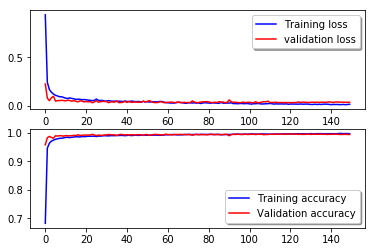

In [37]:
index=np.random.randint(nets)
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history[index].history['loss'], color='b', label="Training loss")
ax[0].plot(history[index].history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history[index].history['acc'], color='b', label="Training accuracy")
ax[1].plot(history[index].history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Number of incorrect predictions: 47 (out of 42,000)


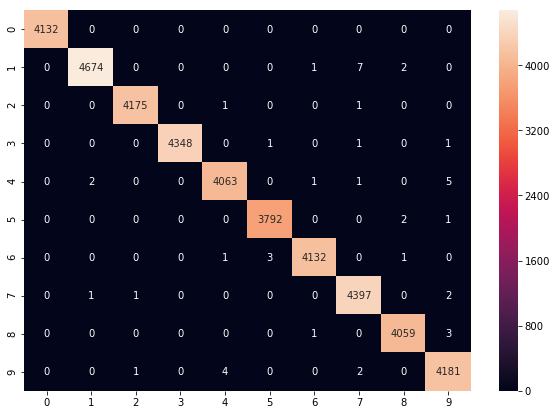

In [38]:
#check confusion matrix from one trained model on training data
index=0
# Predict the values from the validation dataset
Y_pred = model[index].predict(df_train_X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(df_train_Y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plt.figure(figsize = (10,7))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
print('Number of incorrect predictions: {} (out of 42,000)'.format(sum(Y_pred_classes - Y_true != 0)))

## Ensemble 5 CNN predictions and submit

In [38]:
X_test = df_test_X

# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission_006.csv",index=False)

## Conclusion


In this kernal, we have built a ensemble of CNNs that can achieve more than 99.7% of classification accuracy on the unseen test data. Based on the LeNet-5 architecture, few advanced techniques are used including data augmentation, ReLU activation, ensembling, bagging, decaying learning rates, dropout, batch normalization, and adam optimization.